## GWO & Hail Environment Relationship
##### Dr. Victor Gensini (Fall 2017)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
import Ngl, datetime, os, calendar
import numpy as np
import pandas as pd
from netCDF4 import date2num,date2index
from netCDF4 import Dataset
from IPython.display import Image
import scipy.ndimage

### GWO data

In [2]:
gwo_file = 'gwo.csv'
gwo_df = pd.read_csv(gwo_file)
formats = '%Y-%m-%d'
gwo_df['date']=pd.to_datetime(gwo_df['date'], format=formats)
gwo_df=gwo_df.set_index(pd.DatetimeIndex(gwo_df['date']))
amp=1
phase=0.5
query='amp>=%s & phase==%s & year>=1979 & year<=2016 & month==4' % (amp,phase)
phase_amp_df = gwo_df.query(query)

### Read in one file to capture lat/lons

In [3]:
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()

In [4]:
phase_st_anoms = np.empty((0,277,349))
nc = Dataset('scp_cin_1979_2016.nc','r',format='NETCDF4_CLASSIC')

In [5]:
mean_scp_daily = np.load('narr_mean_scp_daily.npy')
#mean_scp_daily_log =  np.load('narr_stdev_scp_daily_log.npy')
stdev_scp_daily =  np.load('narr_stdev_scp_daily.npy')
#stdev_scp_daily_log =  np.load('narr_stdev_scp_daily_log.npy')
print mean_scp_daily.shape

(365, 277, 349)


In [6]:
for dt in phase_amp_df['date']+datetime.timedelta(hours=21):
    if calendar.isleap(dt.year)==True:
        tt=dt.timetuple().tm_yday-2
    else:
        tt=dt.timetuple().tm_yday-1
    day_mean_scp=mean_scp_daily[tt][:][:]
    #day_mean_scp_log=mean_scp_daily_log[tt][:][:]
    day_stdev_scp=stdev_scp_daily[tt][:][:]
    #day_stdev_scp_log=stdev_scp_daily_log[tt][:][:] 
    idex = date2index(dt,nc['time'])
    scp = nc.variables["scp"][idex][:][:]
    cin  = nc.variables["sbcin"][idex][:][:]
    #cin mask
    term5 = np.fabs(cin)
    term5[np.fabs(cin)>50]=0.
    term5[np.fabs(cin)<=50]=1.
    scp = scp * term5
    scp[scp<0]=0.
    anom = scp-day_mean_scp
    st_anom = anom/day_stdev_scp
    phase_st_anoms = np.append(phase_st_anoms,[anom],axis=0)
print phase_st_anoms.shape

(88, 277, 349)


In [7]:
mean_ph1 = np.mean(phase_st_anoms,axis=0)

#Guassian smooth probs
sigma = 2
mean_ph1 = scipy.ndimage.filters.gaussian_filter(mean_ph1,sigma,order=0)

In [8]:
wkres           =  Ngl.Resources()                      #-- generate an resources object for workstation
wkres.wkWidth   =  2500                                 #-- plot resolution 2500 pixel width
wkres.wkHeight  =  2000                                 #-- plot resolution 2000 pixel height
wks_type        = "png"                                 #-- graphics output type
wks             =  Ngl.open_wks(wks_type,"test",wkres)  #-- Open the Ngl canvas for drawing

In [9]:
res                        =  Ngl.Resources()
res.mpFillOn               = True                     # map fill on
res.mpOutlineOn            = True                     # map outline on
res.mpLandFillColor        = "transparent"            # fill land transparent
res.mpOceanFillColor       = "grey"                   # fill ocean grey
res.mpInlandWaterFillColor = "grey"                   # fill inland water grey
res.mpFillDrawOrder        = "PostDraw"               # draw mapfill after contour plot
res.mpGridAndLimbOn        = True                     # turn on gridlines
res.mpProjection           = "LambertConformal"       # set map projection
res.cnLevelSelectionMode   = "ManualLevels"           # set manual contour levels
res.cnMinLevelValF         = -.5                    # set contour min value
res.cnMaxLevelValF         = .5                  # set contour max value
res.cnLevelSpacingF        = .1                       # set contour interval
res.cnFillOn               = True                     # turn on contour fill
res.cnLinesOn              = False                    # turn off contour lines
res.cnLineLabelsOn         = False                    # turn off line labels
res.cnFillMode             = "RasterFill"             # These two resources
res.trGridType             = "TriangularMesh"         # can speed up plotting.
res.cnFillPalette          = "amwg_blueyellowred"     # pick a colorbar
res.mpOutlineBoundarySets  = "GeophysicalAndUSStates" # pick map outline boundaries
res.mpLimitMode            = "Corners"                #-- select a sub-region
res.mpLeftCornerLonF       =  -120                    #-- left longitude value
res.mpRightCornerLonF      =  -60                     #-- right longitude value
res.mpLeftCornerLatF       =  20                      #-- left latitude value
res.mpRightCornerLatF      =  50                      #-- right latitude value
res.lbOrientation          = "horizontal"             # colorbar label orientation; default is vertical
res.sfXArray               = lons                     # set array of x values from netCDF longitudes
res.sfYArray               = lats                     # set array of y valyes from netCDF latitudes
res.tiMainString           = "April S Phase 1 (1979-2016)"  # Make a plot title
res.tiMainFontHeightF      = 0.015                    # set plot font title size
res.mpLambertParallel1F    = 33                       # set lambert 1st parallel
res.mpLambertParallel2F    = 45                       # set lambert 2nd parallel
res.mpLambertMeridianF     = -95                      # set lambert centering longitude
plot = Ngl.contour_map(wks,mean_ph1,res)               # make a countour map
Ngl.end()                                             # close the resources

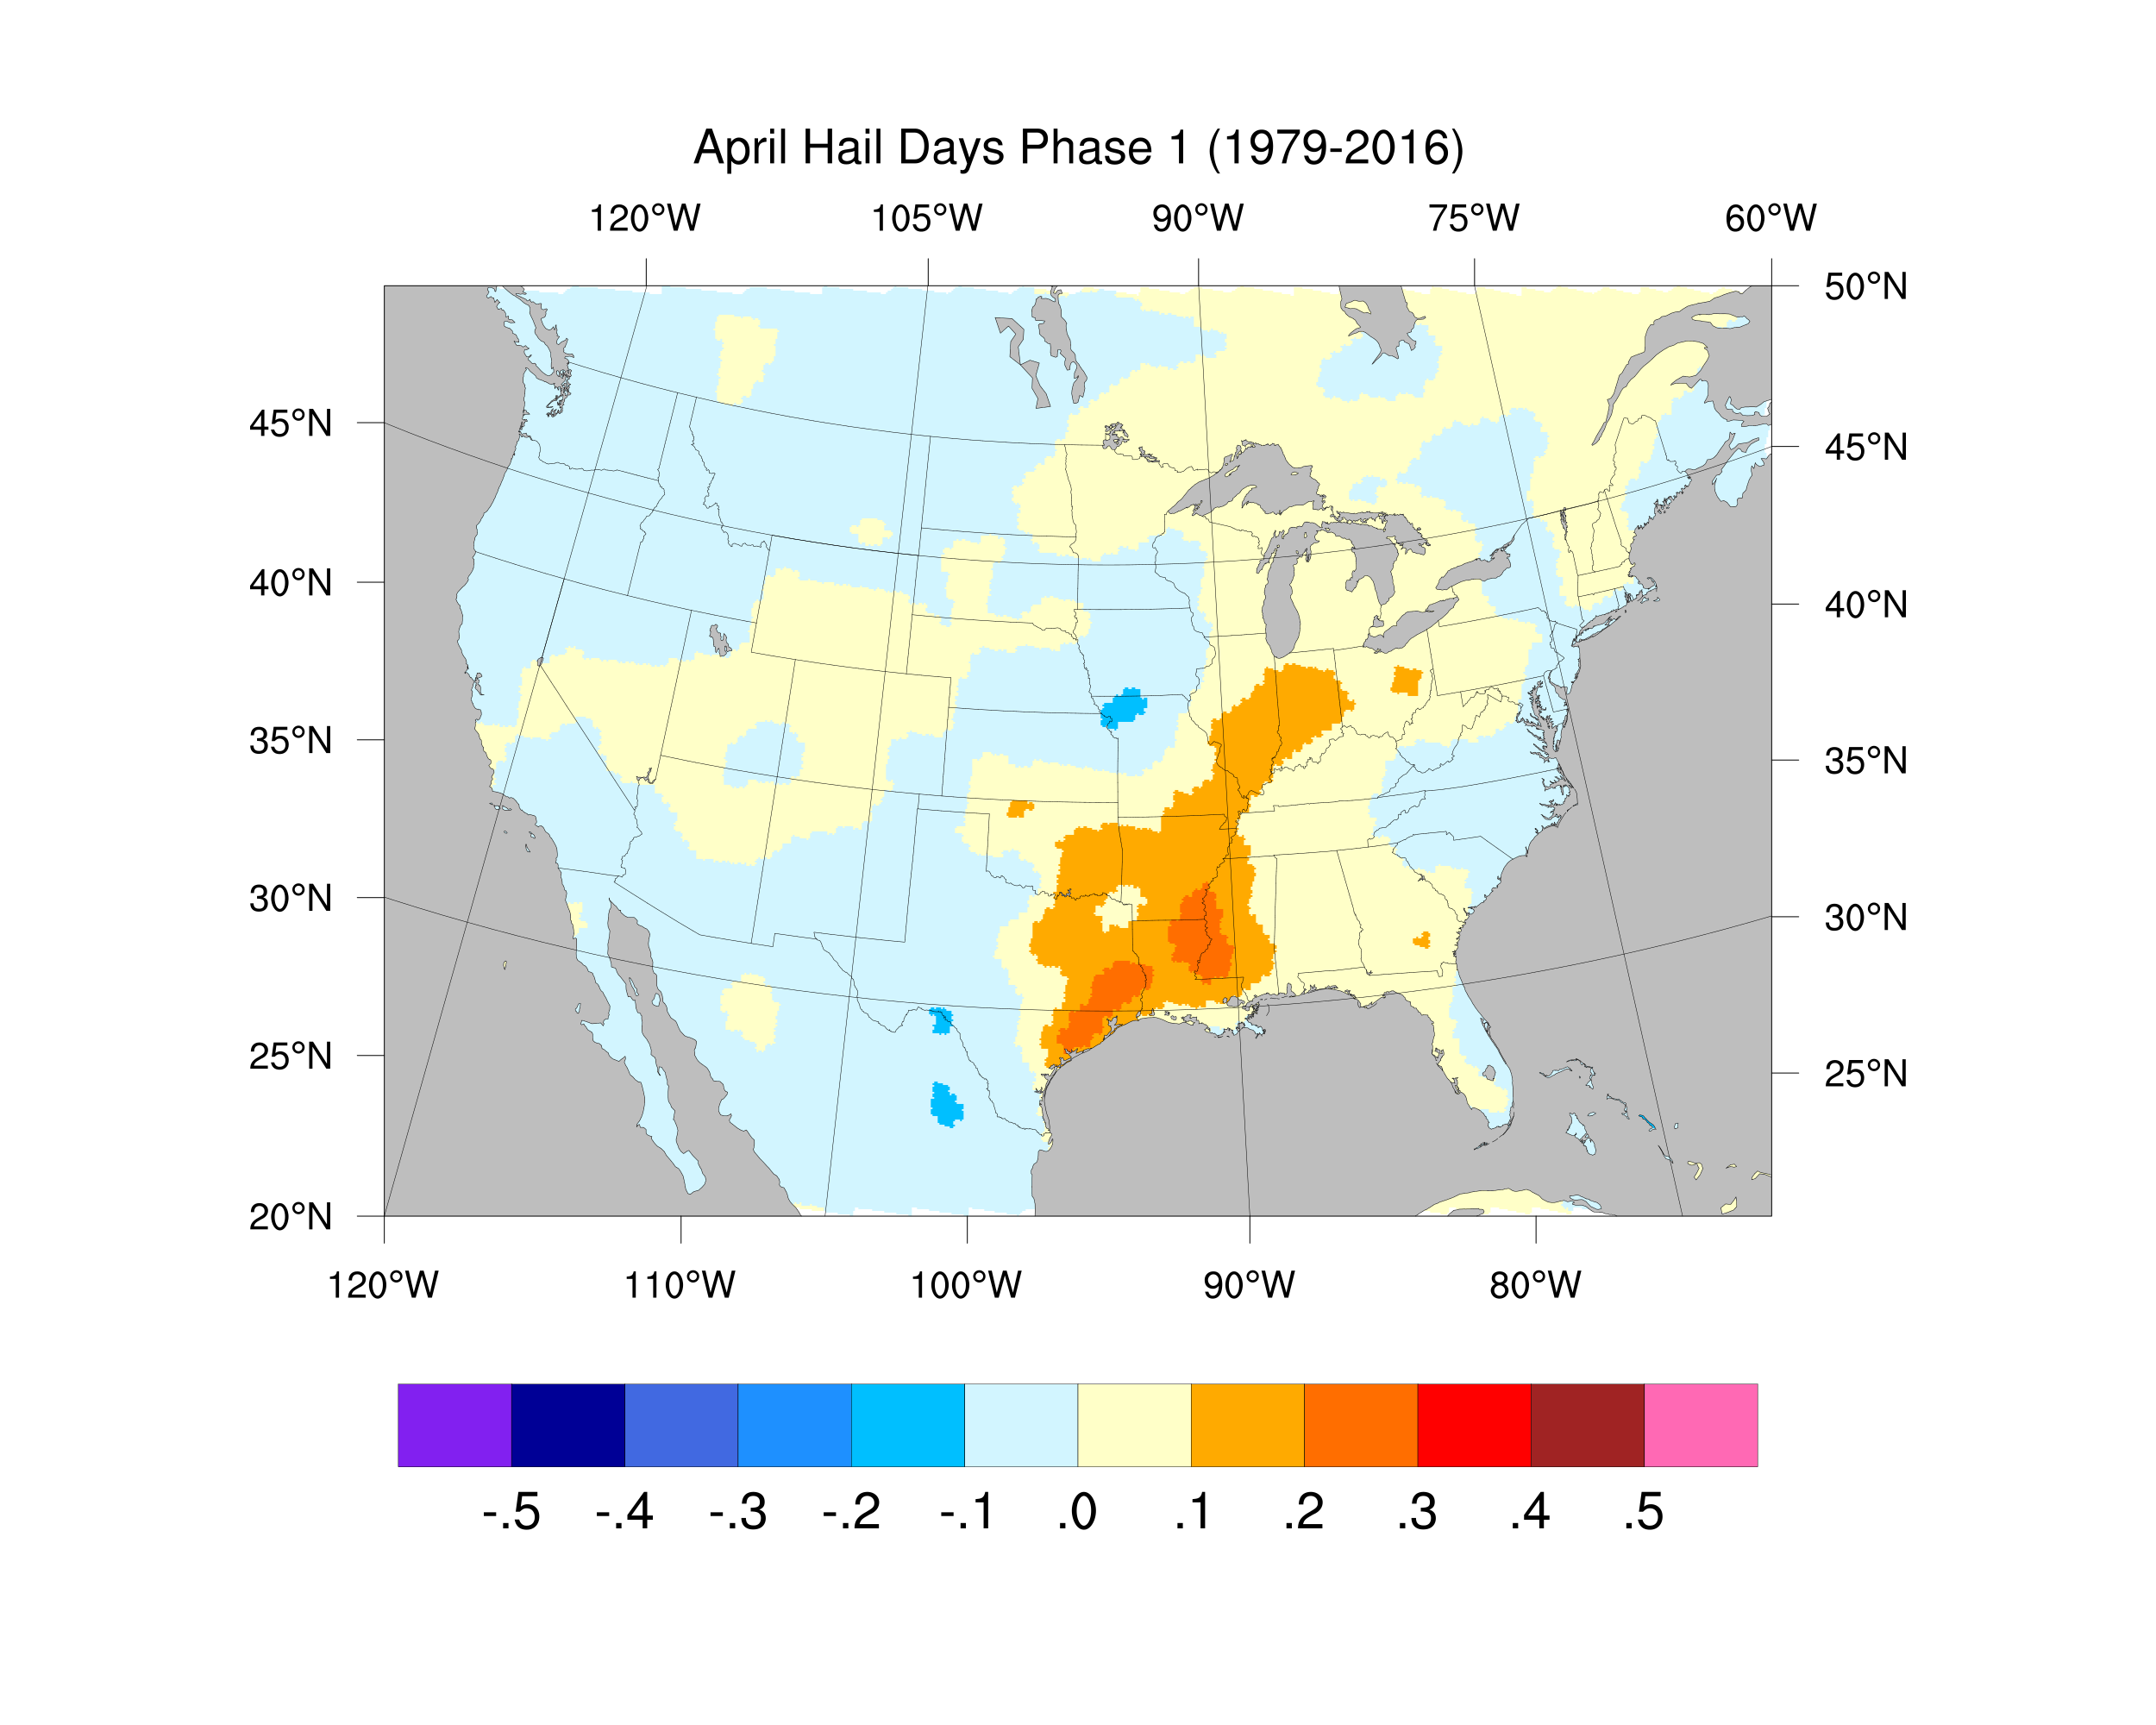

In [10]:
Image(filename='test.png')